In [1]:
# 1. Import thư viện cần thiết
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from keras.optimizers import Adam, Adamax, Ftrl

2024-06-14 15:41:10.608348: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 15:41:10.608472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 15:41:10.727043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_excel('/kaggle/input/bnb-data/bnb_processed_data.xlsx')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adamax(learning_rate=0.001), loss='mean_squared_error')

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 100)       │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100, 100)       │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,201 (594.54 KB)

 Trainable params: 152,201 (594.54 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0513 - val_loss: 0.0035
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [12]:
# EVALUATION
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_rmse = np.sqrt(mean_squared_error(ytest, y_pred))

test_mse = mean_squared_error(ytest, y_pred)

test_mae = mean_absolute_error(ytest, y_pred)

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

# Print evaluation metrics
print(f"Testing RMSE: {test_rmse}")
print(f"Testing MSE: {test_mse}")
print(f"Testing MAE: {test_mae}")
print(f"Testing MAPE: {test_mape}%")

Testing RMSE: 549.5004431432908
Testing MSE: 301950.737014673
Testing MAE: 547.1824791482886
Testing MAPE: 66024.65504005578%


In [13]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.55924481 0.54920325 0.55884414 0.56906318 0.58871229 0.57873439
 0.60991559 0.58591298 0.59796771 0.60273301 0.60782863 0.61481403
 0.57823327 0.62978711 0.69924355 0.71845946 0.72066216 0.78041459
 0.77042396 0.79315809 0.93227844 0.89089661 0.93564248 0.85155461
 0.84301543 0.81820905 0.7469488  0.82142588 0.81624461 0.8140389
 0.81419041 0.83837673 0.86754205 0.85662036 0.84815731 0.8613035
 0.90540851 0.88793645 0.89677975 0.85098648 0.81239233 0.82940903
 0.86456128 0.85484399 0.86534962 0.86255113 0.86675161 0.85764064
 0.90154532 0.89375583 0.88097825 0.81782285 0.83721153 0.81568373
 0.79310349 0.78798066 0.81462955 0.81870755 0.84282773 0.85582406
 0.89477895 0.8966777  0.89854696 0.9074302  0.88296733 0.8799883
 0.88651788 0.87565198 0.85412527 0.82849135 0.82716841 0.86691594
 0.86516916 0.87461512 0.86911543 0.85262169 0.86869745 0.88045575
 0.86483242 0.87444629 0.87804328 0.8738145  0.83644399 0.8595077
 0.84017087 0.85816296 0.85711658 0.84833749 0.8873360

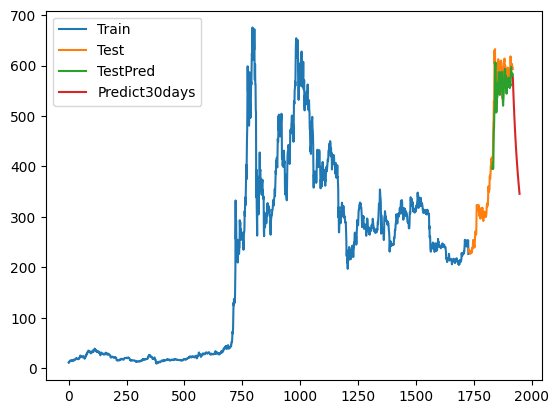

In [14]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Predict30days'])
plt.show()

<h2> 60 days

In [15]:
# 14. Dự báo 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.55924481 0.54920325 0.55884414 0.56906318 0.58871229 0.57873439
 0.60991559 0.58591298 0.59796771 0.60273301 0.60782863 0.61481403
 0.57823327 0.62978711 0.69924355 0.71845946 0.72066216 0.78041459
 0.77042396 0.79315809 0.93227844 0.89089661 0.93564248 0.85155461
 0.84301543 0.81820905 0.7469488  0.82142588 0.81624461 0.8140389
 0.81419041 0.83837673 0.86754205 0.85662036 0.84815731 0.8613035
 0.90540851 0.88793645 0.89677975 0.85098648 0.81239233 0.82940903
 0.86456128 0.85484399 0.86534962 0.86255113 0.86675161 0.85764064
 0.90154532 0.89375583 0.88097825 0.81782285 0.83721153 0.81568373
 0.79310349 0.78798066 0.81462955 0.81870755 0.84282773 0.85582406
 0.89477895 0.8966777  0.89854696 0.9074302  0.88296733 0.8799883
 0.88651788 0.87565198 0.85412527 0.82849135 0.82716841 0.86691594
 0.86516916 0.87461512 0.86911543 0.85262169 0.86869745 0.88045575
 0.86483242 0.87444629 0.87804328 0.8738145  0.83644399 0.8595077
 0.84017087 0.85816296 0.85711658 0.84833749 0.8873360

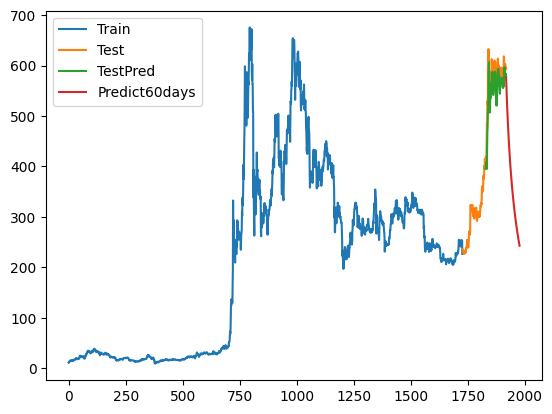

In [16]:
# 15.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Predict60days'])
plt.show()

<h2> 90 days

In [17]:
# 16. Dự báo 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.55924481 0.54920325 0.55884414 0.56906318 0.58871229 0.57873439
 0.60991559 0.58591298 0.59796771 0.60273301 0.60782863 0.61481403
 0.57823327 0.62978711 0.69924355 0.71845946 0.72066216 0.78041459
 0.77042396 0.79315809 0.93227844 0.89089661 0.93564248 0.85155461
 0.84301543 0.81820905 0.7469488  0.82142588 0.81624461 0.8140389
 0.81419041 0.83837673 0.86754205 0.85662036 0.84815731 0.8613035
 0.90540851 0.88793645 0.89677975 0.85098648 0.81239233 0.82940903
 0.86456128 0.85484399 0.86534962 0.86255113 0.86675161 0.85764064
 0.90154532 0.89375583 0.88097825 0.81782285 0.83721153 0.81568373
 0.79310349 0.78798066 0.81462955 0.81870755 0.84282773 0.85582406
 0.89477895 0.8966777  0.89854696 0.9074302  0.88296733 0.8799883
 0.88651788 0.87565198 0.85412527 0.82849135 0.82716841 0.86691594
 0.86516916 0.87461512 0.86911543 0.85262169 0.86869745 0.88045575
 0.86483242 0.87444629 0.87804328 0.8738145  0.83644399 0.8595077
 0.84017087 0.85816296 0.85711658 0.84833749 0.8873360

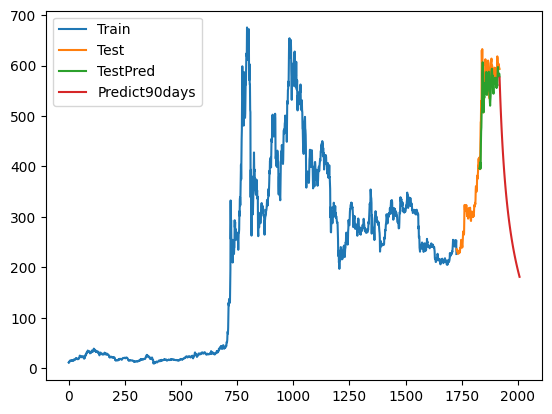

In [18]:
# 17.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Predict90days'])
plt.show()